In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wisps


%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spem
import splat.simulate as spsim
import splat.evolve as spev

import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [6.0, 3.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

import astropy.units as u
import seaborn as sns 
from astropy import stats as astrostats
import splat
from astropy.coordinates import  SkyCoord

In [2]:
vols=pd.read_pickle(wisps.OUTPUT_FILES+'/volumes.pkl')
volumes=np.nansum(np.array(vols), axis=0)[:,0]

In [3]:
phi=pd.read_pickle(wisps.OUTPUT_FILES+'/phi.pkl')

In [4]:
cands=wisps.datasets['candidates']
cands['spt']=cands.spt.apply(splat.typeToNum)
maskd=(cands[(cands.spt>=20)&(cands.spt<=38.0)]).spt
n=np.histogram(maskd.values, bins=18)[0]

In [5]:
spgrid=np.linspace(20, 38, 18)

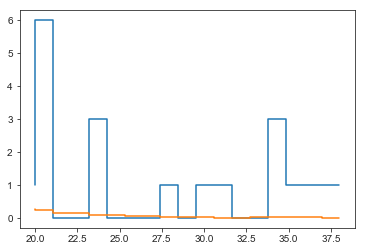

In [6]:
fig, ax=plt.subplots()
plt.step(spgrid, n)
plt.step(spgrid, phi*volumes)

In [7]:
import scipy.stats as st
from scipy import integrate

In [8]:
mind=1.0
maxd=3*10**5

In [11]:
norm=volume_correction(-10**-5, -10**-5, -10**-5, 3*10**5, 1.0)

In [12]:
norm

1.3040764745841926e-07

In [10]:
def volume_correction(x, y, z, dmax, dmin):
    dds=np.linspace(dmin,dmax,10)
    r=(x**2+y**2)**0.5
    rs=np.linspace(0,r,10)
    zs=np.linspace(0,z,10)
    rho=spsim.galactic_density_juric(rs, zs).value
    
    return 1.0-float(integrate.trapz(rho*(dds**2),x=dds))/float(integrate.trapz(dds**2,x=dds))

In [13]:
class my_pdf(st.rv_continuous):
    def _cdf(self,d):
        nu=np.random.uniform(-1,1)
        theta=np.random.uniform(-np.pi, np.pi)
        x=d*((1-nu**2)**0.5)*np.cos(theta)
        y=d*((1-nu**2)**0.5)*np.sin(theta)
        z=d*nu
        return  volume_correction(x, y, z, d, 1.0)/norm
my_cv = my_pdf(a=mind, b=maxd, name='my_pdf')

In [14]:
scls=np.linspace(mind*2, maxd, 1000)

In [15]:
maxd, mind

(300000, 1.0)

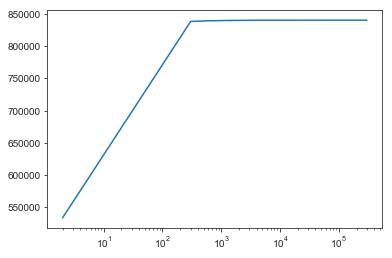

In [16]:
plt.plot(scls*mind, [ volume_correction(-10**2, -10**2, -10**2, mind*i , 1.0)/norm for i in scls])
plt.xscale('log')

In [17]:
d=my_cv.rvs(size=10000)

In [18]:
nu=np.random.uniform(-1,1, 10000)
theta=np.random.uniform(-np.pi, np.pi, 10000)
x=d*((1-nu**2)**0.5)*np.cos(theta)
y=d*((1-nu**2)**0.5)*np.sin(theta)
z=d*nu

In [19]:
coord=SkyCoord(x=x, y=y, z=z, unit='pc', representation_type='cartesian').galactic

In [ ]:
#coord

Text(0.5, 0, 'Z')

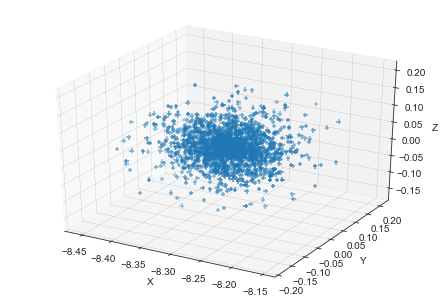

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure()

ax = Axes3D(fig) #<-- Note the difference from your original code...

#a#x.scatter(coord.cartesian.x/1000, coord.cartesian.y/1000, coord.cartesian.z/1000, marker='+')
ax.scatter(coord.galactocentric.cartesian.x/1000, coord.galactocentric.cartesian.y/1000, coord.galactocentric.cartesian.z/1000, marker='+')
#ax.plot(xsur, ysur, zsur, '+')
#ax.plot(x, y, z, '+')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [ ]:
xg, yg, zg=coord.galactocentric.cartesian.xyz

In [ ]:
d=(xg**2+yg**2+zg**2)**0.5

In [ ]:
fig, ax=plt.subplots()
sns.distplot((d-8000*u.pc), ax=ax)
ax.set_xscale('log')